# Overview 
This notebook contains the analysis of the London Tweets'sentiment.  

# Sentiment scores and socio-demographic data
    
NB: no need to exclude bots explicitly, because sentiments where not calculated for them

In [2]:
import psycopg2
import pandas as pd
import geopandas as gpd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# load initial data
conn=psycopg2.connect("")
cur = conn.cursor()
cur.execute("select msoa2011code, AVG(sentiment), COUNT(*) from london_twitter where msoa2011code is not null and sentiment is not null group by msoa2011code")
avg_msoa_sents = cur.fetchall()
avg_msoa_sents = pd.DataFrame(avg_msoa_sents, columns=["code","sentiment","tw_count"])
avg_msoa_sents = avg_msoa_sents.astype({"code": str, "sentiment": float, "tw_count": int})
msoa_poly = gpd.GeoDataFrame.from_postgis("select * from london_msoa_2011_gen_4326", conn, geom_col='geom' )
joined_msoa_poly = msoa_poly.join(avg_msoa_sents.set_index('code'), on='code', how='inner')
conn.close()

msoa_data_selected = pd.read_csv("msoa-data-selected.csv", sep=";")

# create dataframe for analysis and save to disk.
df = pd.merge(joined_msoa_poly, msoa_data_selected, how='left', left_on='code', right_on='MSOA Code')
df = df.loc[:, ['code', 'tw_count', 'sentiment', 'age_0-15_perc', 'age_16-29_perc', 'age_30-44_perc', 'age_45-64_perc', 'age_65_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'house_price_2012']]
df['tweets_ihs'] = np.arcsinh(df['tw_count'])
df['h_prices_ihs'] = np.arcsinh(df['house_price_2012'])
display(df.head())
df.to_csv("sentiments_sociodem_msoa.csv")

,code,tw_count,sentiment,age_0-15_perc,age_16-29_perc,age_30-44_perc,age_45-64_perc,age_65_perc,qual_4min,hh_1p_perc,hh_cpl_perc,hh_cpl_kids_perc,BAME_perc,house_price_2012,tweets_ihs,h_prices_ihs
0,E02000235,451,1.248337,21.039036,14.466131,20.335821,29.219288,14.939724,28.315155,21.826281,26.688938,25.835189,18.671068,300000.0,6.804616,13.304685
1,E02000851,3556,1.143420,17.563025,19.843938,27.587035,20.504202,14.501801,23.889556,43.826257,18.496828,14.982919,24.909964,181000.0,8.869539,12.799399
2,E02000850,1289,1.142746,20.690659,16.160636,22.233000,27.577845,13.337860,19.924338,25.439683,24.201139,25.687392,23.513435,247650.0,7.854769,13.112919
3,E02000855,514,1.097276,19.725183,15.179145,20.020547,28.033903,17.041223,28.945679,25.271829,23.789127,26.326194,16.977013,365000.0,6.935371,13.500800
4,E02000849,370,1.205405,20.587842,17.368069,23.740815,25.718103,12.585170,22.471610,29.912875,23.039690,22.265247,19.345357,250000.0,6.606652,13.122363


# Correlations 

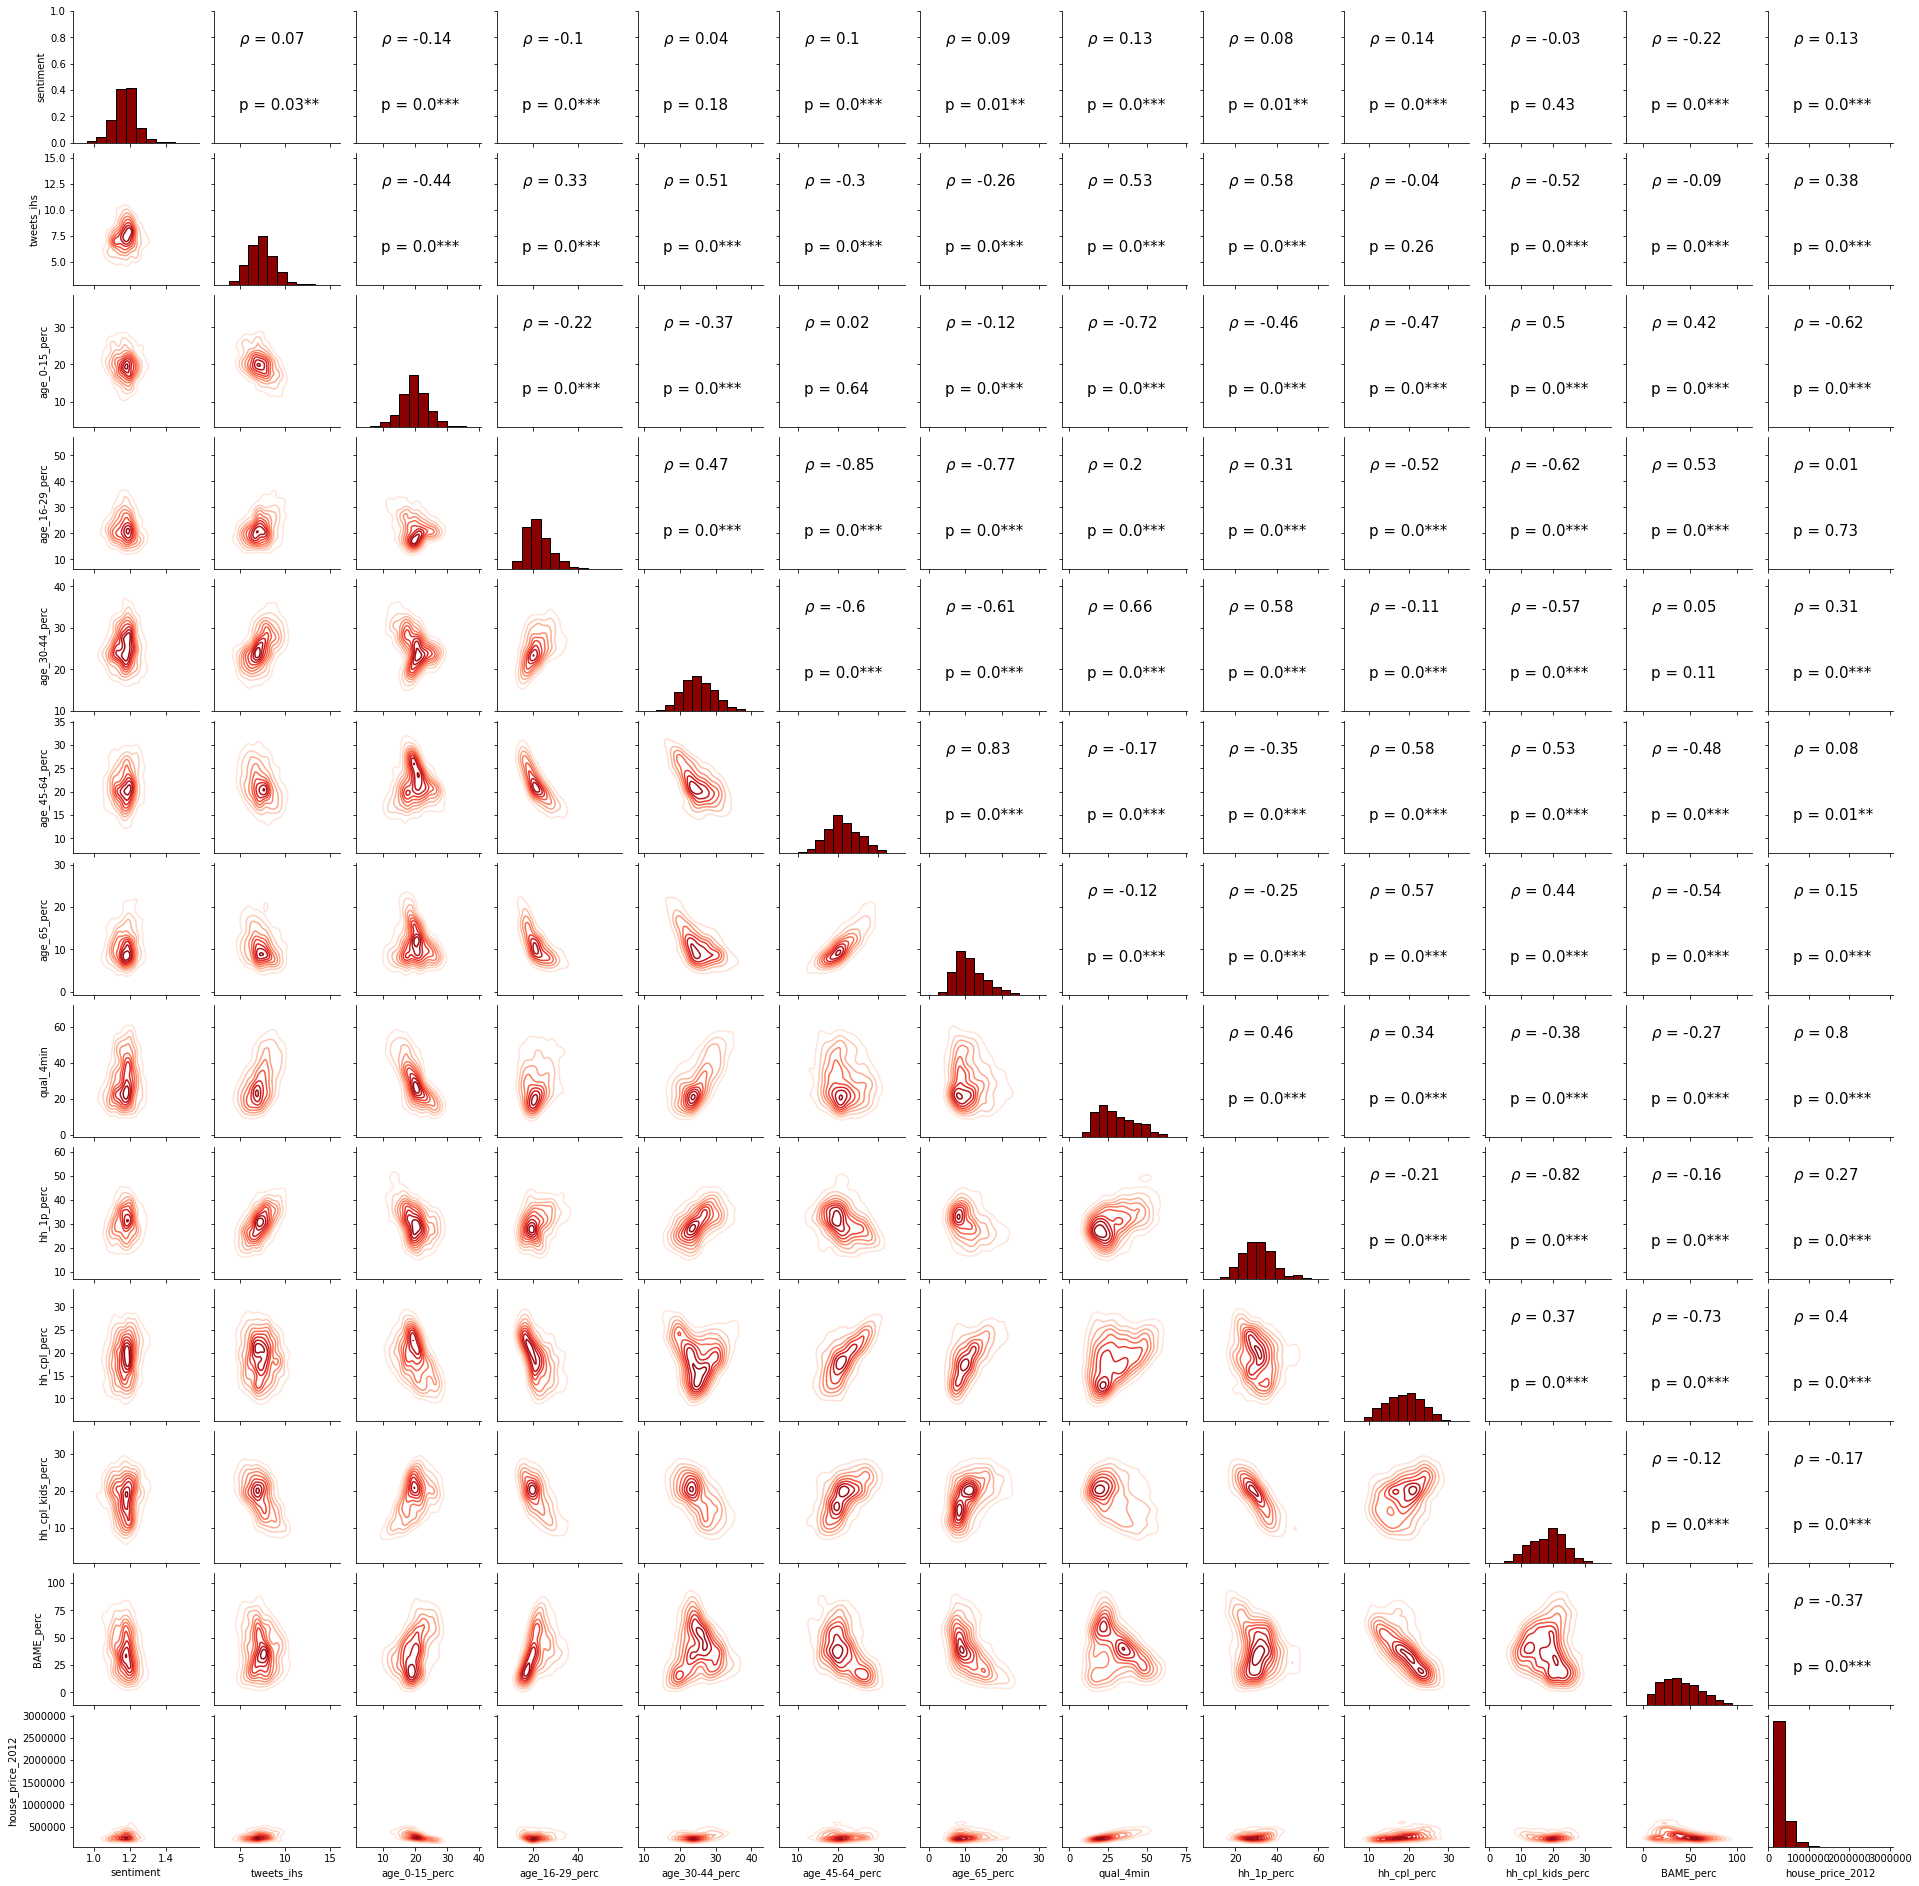

In [3]:
"""creates overview figure of correlations."""
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

df = pd.read_csv("sentiments_sociodem_msoa.csv")

def corr(x, y, **kwargs):
    """calculates correlation coefficient between two arrays."""
    # coef = np.corrcoef(x, y)[0][1]
    coef = stats.spearmanr(x, y)
    # coef = stats.pearsonr(x, y)

    # Make the label
    label = r'$\rho$ = ' + str(round(coef[0], 2))
    if round(coef[1], 2) < 0.01:
        stars = '***'
    elif round(coef[1], 2) < 0.05:
        stars = '**'
    elif round(coef[1], 2) < 0.1:
        stars = '*'
    else:
        stars = ''

    label2 = 'p = ' + str(round(coef[1], 2)) + stars

    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy=(0.2, 0.75), size=15, xycoords=ax.transAxes)
    ax.annotate(label2, xy=(0.2, 0.25), size=15, xycoords=ax.transAxes)


# Create a pair grid instance
grid = sns.PairGrid(data=df,
                    vars=['sentiment', 'tweets_ihs', 'age_0-15_perc', 'age_16-29_perc', 'age_30-44_perc', 'age_45-64_perc', 'age_65_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'house_price_2012'],
                    height=2)

# Map the plots to the locations
grid = grid.map_upper(corr)
grid = grid.map_lower(sns.kdeplot, cmap='Reds')
grid = grid.map_diag(plt.hist, bins=10, edgecolor='k', color='darkred')

# Modeling sentiment

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     6.973
Date:                Tue, 03 Nov 2020   Prob (F-statistic):           3.98e-08
Time:                        20:51:58   Log-Likelihood:                 1367.1
No. Observations:                 983   AIC:                            -2718.
Df Residuals:                     975   BIC:                            -2679.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.2785      0.108     11.

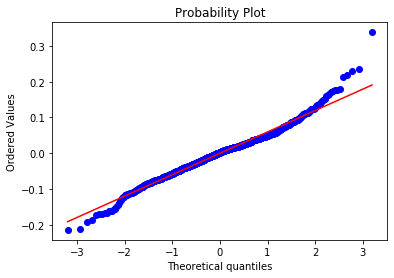

In [7]:
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt

# load analysis dataframe again.
df = pd.read_csv("sentiments_sociodem_msoa.csv")

# calculate sentiment model 1
sent1_model_skl = linear_model.LinearRegression().fit(df[['tweets_ihs', 'age_0-15_perc', 'age_45-64_perc', 'qual_4min', 'hh_cpl_perc', 'BAME_perc', 'h_prices_ihs']], df[['sentiment']])
X = sm.add_constant(analysis_df[['tweets_ihs', 'age_0-15_perc', 'age_45-64_perc', 'qual_4min', 'hh_cpl_perc', 'BAME_perc', 'h_prices_ihs']])
sent1_model_sm = sm.OLS(df[['sentiment']], X).fit()
print(sent1_model_sm.summary())

# VIF, Shapiro-Wilkes
print("VIF: ", pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns))
print("Shapiro-Wilkes: ", stats.shapiro(sent1_model_sm.resid))
res = stats.probplot(sent1_model_sm.resid, plot=plt)
plt.show()

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     8.093
Date:                Tue, 03 Nov 2020   Prob (F-statistic):           1.50e-08
Time:                        20:57:05   Log-Likelihood:                 1366.9
No. Observations:                 983   AIC:                            -2720.
Df Residuals:                     976   BIC:                            -2686.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.2724      0.107     11.

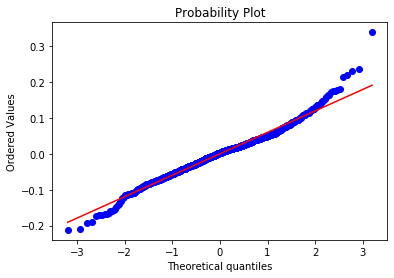

In [8]:
# calculate sentiment model 2
filtered = df['tw_count']>20
f_df = df[filtered]
sent2_model_skl = linear_model.LinearRegression().fit(f_df[['age_0-15_perc', 'age_45-64_perc', 'qual_4min', 'hh_cpl_perc', 'BAME_perc', 'h_prices_ihs']], f_df[['sentiment']])
X = sm.add_constant(f_df[['age_0-15_perc', 'age_45-64_perc', 'qual_4min', 'hh_cpl_perc', 'BAME_perc', 'h_prices_ihs']])
sent2_model_sm = sm.OLS(f_df[['sentiment']], X).fit()
print(sent2_model_sm.summary())

# VIF, Shapiro-Wilkes
print("VIF: ", pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns))
print("Shapiro-Wilkes: ", stats.shapiro(sent2_model_sm.resid))
res = stats.probplot(sent2_model_sm.resid, plot=plt)
plt.show()

# Sentiment scores and IMD 2019

SpearmanrResult(correlation=-0.13356544337263884, pvalue=2.6554675218379622e-05)
(-0.1148057268680963, 0.00030995275765357774)


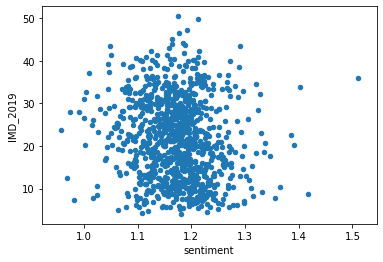

In [12]:
import pandas as pd
import geopandas as gpd
from scipy import stats

# aggregate IMD on MSOA basis
lsoa_poly = gpd.read_file("LSOA_2011_London_gen_MHW.shp")
imd_2019 = pd.read_csv("ID 2019 for London.csv")
lsoa_imd_poly = pd.merge(lsoa_poly, imd_2019, how='left', left_on='LSOA11CD', right_on='LSOA code (2011)')
lsoa_imd_poly = lsoa_imd_poly.filter(items=['LSOA11CD', 'MSOA11CD', 'Index of Multiple Deprivation (IMD) Score', 'geometry'])
lsoa_imd_poly = lsoa_imd_poly.rename(columns={"Index of Multiple Deprivation (IMD) Score": "IMD_2019"})
lsoa_imd_mean = lsoa_imd_poly.groupby('MSOA11CD')['IMD_2019'].aggregate('mean')

df = pd.read_csv("sentiments_sociodem_msoa.csv")
filtered = df['tw_count']>20
f_df = df[filtered]

f_df = pd.merge(f_df, lsoa_imd_mean, how='left', left_on='code', right_on='MSOA11CD')
print(stats.spearmanr(f_df['sentiment'], f_df['IMD_2019']))
print(stats.pearsonr(f_df['sentiment'], f_df['IMD_2019']))
f_df.plot.scatter(x='sentiment', y='IMD_2019')
plt.show()

# Sentiments and LOAC

In [13]:
import psycopg2
import pandas as pd
import geopandas as gpd
from scipy.stats import entropy
from scipy import stats
import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp

# create data frame
conn=psycopg2.connect("")
cur = conn.cursor()
cur.execute("select ward2011code, AVG(sentiment), AVG(sent_vader), AVG(sentpos_tfidflr), COUNT(*), COUNT(*) filter (where sentiment=0) from london_twitter where ward2011code is not null and sentiment is not null group by ward2011code")
avg_ward_sents = cur.fetchall()
avg_ward_sents = pd.DataFrame(avg_ward_sents, columns=["code","sentiment","sent_vader", "sentpos_tfidflr","tw_count", "tw_neg_count"])
avg_ward_sents = avg_ward_sents.astype({"code": str, "sentiment": float, "sent_vader": float, "sentpos_tfidflr": float,"tw_count": int,"tw_neg_count": int})
ward_poly = gpd.GeoDataFrame.from_postgis("select * from london_ward_citymerged_4326", conn, geom_col='geom' )
conn.close()

wards_loac = pd.read_csv("LOAC ward dashboard_count.csv")

joined_ward_poly = ward_poly.join(avg_ward_sents.set_index('code'), on='gss_code', how='inner')
joined_ward_poly = joined_ward_poly.join(wards_loac.set_index('Ward Code'), on='gss_code', how='inner')

jwp = joined_ward_poly
jwp.head()

,gid,name,gss_code,hectares,nonld_area,lb_gss_cd,borough,poly_id,geom,sentiment,...,E1,E2,F1,F2,G1,G2,H1,H2,Unnamed: 31,Unnamed: 32
0,1,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840.0,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",1.238650,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,15.0,NaN,37.0
1,2,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160.0,"MULTIPOLYGON (((-0.30846 51.37586, -0.30834 51...",1.091549,...,1.0,0.0,0.0,6.0,0.0,0.0,2.0,6.0,NaN,45.0
2,3,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449.0,"MULTIPOLYGON (((-0.30385 51.39249, -0.30375 51...",1.115108,...,4.0,2.0,2.0,9.0,1.0,1.0,10.0,0.0,NaN,33.0
3,4,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456.0,"MULTIPOLYGON (((-0.26990 51.38845, -0.26975 51...",1.196242,...,0.0,0.0,0.0,1.0,1.0,0.0,14.0,1.0,NaN,29.0
4,5,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161.0,"MULTIPOLYGON (((-0.24662 51.39921, -0.24672 51...",1.129723,...,0.0,0.0,0.0,14.0,4.0,2.0,2.0,1.0,NaN,30.0


In [14]:
# determine predominant group
df = jwp.iloc[:,16:24]
group_max = df.idxmax(axis=1)
group_max

0      H
1      C
2      F
3      H
4      F
      ..
619    A
620    A
621    A
622    A
623    A
Length: 624, dtype: object

In [15]:
# calculate diversity index (Shannon entropy)
shannon = []
for index,ward in df.iterrows():
    row_list = [ward.A, ward.B, ward.C, ward.D, ward.E, ward.F, ward.G, ward.H]
    #print(row_list, entropy(row_list))
    shannon.append(entropy(row_list))   

In [16]:
# add info and save to csv
jwp['group'] = group_max
jwp['shannon'] = shannon
jwp['tw_neg_ratio'] = jwp['tw_neg_count'] / jwp['tw_count']
jwp.to_csv('sentiments_groups_wards.csv',columns=['gss_code','group','tw_count', 'tw_neg_count', 'tw_neg_ratio', 'sentiment', 'sent_vader', 'sentpos_tfidflr', 'shannon'])

In [17]:
# group by predominant groups and calculate average sentiment
group_stats_means = jwp[['group','tw_count', 'tw_neg_count', 'tw_neg_ratio', 'sentiment', 'sent_vader', 'sentpos_tfidflr', 'shannon']].groupby('group').mean()
display(group_stats_means)

# compare average sentiments per wards grouped by predominant group

for attribute in ['tw_neg_ratio', 'sentiment', 'sent_vader', 'sentpos_tfidflr', 'shannon']:
    group_arrays = []
    for group in jwp.group.unique():
        is_group = jwp['group']==group 
        filtered = jwp[is_group]
        group_arrays.append(filtered[attribute].to_list())
    print(attribute, stats.kruskal(group_arrays[0],group_arrays[1],group_arrays[2],group_arrays[3],group_arrays[4],group_arrays[5],group_arrays[6],group_arrays[7]))

for attribute in ['tw_neg_ratio', 'sentiment', 'sent_vader', 'sentpos_tfidflr', 'shannon']:
    group_arrays = []
    for group in jwp.group.unique():
        is_group = jwp['group']==group 
        filtered = jwp[is_group]
        group_arrays.append(filtered[attribute].to_list())
    print(attribute, stats.f_oneway(group_arrays[0],group_arrays[1],group_arrays[2],group_arrays[3],group_arrays[4],group_arrays[5],group_arrays[6],group_arrays[7]))

,tw_count,tw_neg_count,tw_neg_ratio,sentiment,sent_vader,sentpos_tfidflr,shannon
group,,,,,,,
A,1012.543478,19.423913,0.018085,1.176882,0.332780,0.739254,0.952716
B,7927.446154,99.538462,0.014615,1.167783,0.299393,0.749562,1.017961
C,1849.188235,42.717647,0.020758,1.148443,0.288305,0.729531,0.744614
D,36185.931818,348.886364,0.010150,1.173851,0.327614,0.757406,0.936666
E,4491.024691,56.061728,0.013599,1.181745,0.319933,0.756307,1.115409
F,3277.741573,53.752809,0.016097,1.181772,0.335179,0.744640,1.162957
G,2125.752941,31.341176,0.016277,1.169248,0.310926,0.742191,0.947356
H,1009.000000,13.144578,0.016244,1.193812,0.352226,0.747852,0.872989


tw_neg_ratio KruskalResult(statistic=40.3378985323801, pvalue=1.0845505548588645e-06)
sentiment KruskalResult(statistic=39.54423927571854, pvalue=1.538565184453568e-06)
sent_vader KruskalResult(statistic=63.02256165317817, pvalue=3.750689245078611e-11)
sentpos_tfidflr KruskalResult(statistic=40.66391799816006, pvalue=9.391954772207215e-07)
shannon KruskalResult(statistic=79.34524892420757, pvalue=1.873153374371136e-14)
tw_neg_ratio F_onewayResult(statistic=4.500788776175208, pvalue=6.625224905851492e-05)
sentiment F_onewayResult(statistic=5.047997044769856, pvalue=1.3893323113630013e-05)
sent_vader F_onewayResult(statistic=7.795200799912819, pvalue=4.665734785385551e-09)
sentpos_tfidflr F_onewayResult(statistic=5.374575390896921, pvalue=5.4277020757905745e-06)
shannon F_onewayResult(statistic=12.908602952618654, pvalue=1.5423367182442983e-15)


In [18]:
for attribute in ['tw_neg_ratio','sentiment', 'sent_vader', 'sentpos_tfidflr', 'shannon']:
    display(attribute, sp.posthoc_conover(jwp, val_col=attribute, group_col='group', p_adjust = 'holm'))

'tw_neg_ratio'

,A,B,C,D,E,F,G,H
A,1.000000,1.000000,9.304113e-01,1.666719e-04,1.000000,1.000000,1.000000,1.000000
B,1.000000,1.000000,1.368904e-01,1.179916e-02,1.000000,1.000000,1.000000,1.000000
C,0.930411,0.136890,1.000000e+00,6.518219e-08,0.014232,1.000000,1.000000,0.067024
D,0.000167,0.011799,6.518219e-08,1.000000e+00,0.033610,0.000144,0.000055,0.008209
E,1.000000,1.000000,1.423159e-02,3.360997e-02,1.000000,1.000000,0.960762,1.000000
F,1.000000,1.000000,1.000000e+00,1.442643e-04,1.000000,1.000000,1.000000,1.000000
G,1.000000,1.000000,1.000000e+00,5.542112e-05,0.960762,1.000000,1.000000,1.000000
H,1.000000,1.000000,6.702415e-02,8.208883e-03,1.000000,1.000000,1.000000,1.000000


'sentiment'

,A,B,C,D,E,F,G,H
A,1.000000,1.000000,6.012529e-02,1.000000,1.000000,1.000000,1.000000,1.307861e-01
B,1.000000,1.000000,1.000000e+00,1.000000,0.351979,0.598182,1.000000,1.394778e-02
C,0.060125,1.000000,1.000000e+00,0.354291,0.000250,0.000684,0.337755,6.703948e-07
D,1.000000,1.000000,3.542912e-01,1.000000,1.000000,1.000000,1.000000,3.623875e-01
E,1.000000,0.351979,2.497652e-04,1.000000,1.000000,1.000000,0.598182,1.000000e+00
F,1.000000,0.598182,6.841980e-04,1.000000,1.000000,1.000000,1.000000,1.000000e+00
G,1.000000,1.000000,3.377547e-01,1.000000,0.598182,1.000000,1.000000,2.868872e-02
H,0.130786,0.013948,6.703948e-07,0.362388,1.000000,1.000000,0.028689,1.000000e+00


'sent_vader'

,A,B,C,D,E,F,G,H
A,1.000000,1.828816e-03,8.166980e-05,1.000000,1.000000,1.000000,0.091558,6.855170e-01
B,0.001829,1.000000e+00,1.000000e+00,0.091558,0.140603,0.000372,1.000000,6.639273e-07
C,0.000082,1.000000e+00,1.000000e+00,0.024147,0.027555,0.000012,0.748615,5.173147e-09
D,1.000000,9.155789e-02,2.414748e-02,1.000000,1.000000,1.000000,0.851400,4.918771e-01
E,1.000000,1.406034e-01,2.755454e-02,1.000000,1.000000,0.810379,1.000000,2.755454e-02
F,1.000000,3.722754e-04,1.164097e-05,1.000000,0.810379,1.000000,0.027555,1.000000e+00
G,0.091558,1.000000e+00,7.486154e-01,0.851400,1.000000,0.027555,1.000000,1.086300e-04
H,0.685517,6.639273e-07,5.173147e-09,0.491877,0.027555,1.000000,0.000109,1.000000e+00


'sentpos_tfidflr'

,A,B,C,D,E,F,G,H
A,1.000000,1.000000,0.696152,0.028507,0.018395,1.000000,1.000000,1.000000
B,1.000000,1.000000,0.026552,0.956873,1.000000,1.000000,1.000000,1.000000
C,0.696152,0.026552,1.000000,0.000042,0.000004,0.064001,0.742486,0.005042
D,0.028507,0.956873,0.000042,1.000000,1.000000,0.275909,0.030285,1.000000
E,0.018395,1.000000,0.000004,1.000000,1.000000,0.275909,0.021134,1.000000
F,1.000000,1.000000,0.064001,0.275909,0.275909,1.000000,1.000000,1.000000
G,1.000000,1.000000,0.742486,0.030285,0.021134,1.000000,1.000000,1.000000
H,1.000000,1.000000,0.005042,1.000000,1.000000,1.000000,1.000000,1.000000


'shannon'

,A,B,C,D,E,F,G,H
A,1.000000,1.000000,8.071649e-04,1.000000,3.297910e-02,1.211997e-03,1.000000,1.000000
B,1.000000,1.000000,2.164065e-05,1.000000,1.000000e+00,1.605972e-01,1.000000,0.130922
C,0.000807,0.000022,1.000000e+00,0.032979,1.062927e-10,8.580566e-14,0.002419,0.160597
D,1.000000,1.000000,3.297910e-02,1.000000,8.311774e-02,8.644108e-03,1.000000,1.000000
E,0.032979,1.000000,1.062927e-10,0.083118,1.000000e+00,1.000000e+00,0.021295,0.000148
F,0.001212,0.160597,8.580566e-14,0.008644,1.000000e+00,1.000000e+00,0.000761,0.000001
G,1.000000,1.000000,2.418524e-03,1.000000,2.129489e-02,7.613378e-04,1.000000,1.000000
H,1.000000,0.130922,1.605972e-01,1.000000,1.482965e-04,1.386560e-06,1.000000,1.000000


Holm correction is recommended, p-values of 1 just show that there is no evidence whatsoever for differences in attribute between the wards of the two predominant groups.

The following are different at the 0.01 signficance level:
Negative Twitter Ratio: D from every other group
Sentiment: CE, CF, CH
Sent_Vader: AB, AC, BF, BH
Sentpost_TFIDFLR: CD, CE, CH
Shannon: AC, BC, CE, CF, CG, DF, EH, FG